### This project depicts a fully featured end-to-end Data Science workflow aimed at building models predictive of employee attrition (whether or not an employee leaves a company, in this case: IBM). This project is broken up into a few main parts:

- Data Acquisition 
- Data Cleaning & Pre-Processing
- Exploratory Data Analysis 
- Feature Engineering
- Dataset Preparation (Feature Encoding/Scaling, Train/Test split, etc.)
- Machine Learning Models, specifically:
-- Logisistic Regression Classification
-- Random Forest Classifier 
- Comparision of Model Results & Best Model Selection 

The tech industry currently has the highest employee turnover rate at 13.2%. Although big tech companies like Google provide great benefits packages and amenities at the office, employees stay at google for an average of 1.1 years. I am hoping that this analysis of employee attrition will help companies look into other variables that may cause employees to leave the company like job involvement, and environment satisfaction. What variables cause employee attrition? 


The dataset used in this analysis is IBM HR Analytics Employee Attrition & Performance. This dataset contains 35 variables that may contribute to employee attrition including, work-life balance, years at the company, age and relationship status. The dataset contains approximately 1470 entries. 

### Imports

In [1]:
# Native
import datetime 
import matplotlib.pyplot as plt 
import os 
import sys

# Non-Native
import numpy as np 
import pandas as pd
import pyspark 
import seaborn as sns
sns.set(style='darkgrid')

#ML Imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold

### Data Acquisition

In [2]:
df = pd.read_csv("attrition.csv")

### Data Cleaning & Pre-Processing

#### Given the dataframe containing the employee data, clean it up by:
- Converting the target variable (Attrition) into a binary variable (0/1)
- Dropping columns that don't appear to be relevant / useful for analysis
- Handing missing / NaN values (in this case, there are none!)


In [3]:
df.drop(['Over18', 'StandardHours'], axis=1)
df['Attrition'].replace(to_replace = dict(Yes = 1, No = 0), inplace=True)

### Exploratory Data Analysis 

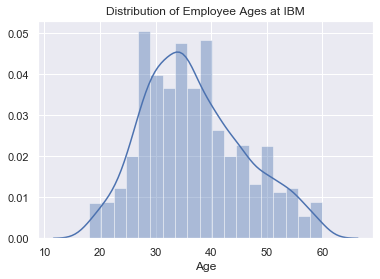

In [4]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Employee Ages at IBM')
sns.distplot(df.Age)

This graph indicates that the average age of Employees at IBM is approximately 35 and is slightly right-skewed indicating that the majority of employees at IBM are young. 

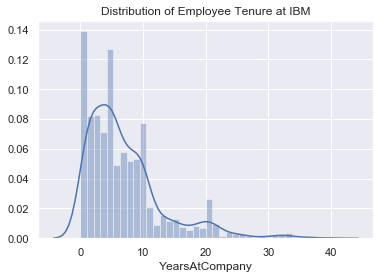

In [5]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Employee Tenure at IBM')
sns.distplot(df.YearsAtCompany)

This graph indicates that the average time spent at IBM is approximately 3 years. 

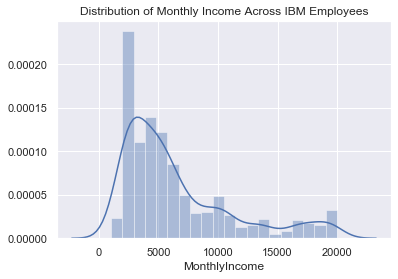

In [6]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Monthly Income Across IBM Employees')
sns.distplot(df.MonthlyIncome)

This graph indicates that the average monthly income is less than 5000 and the graph is right-skewed indicating that the majority of the employees make 5000 or less. 

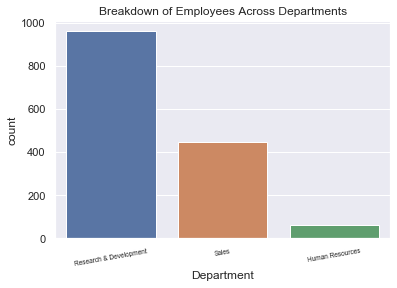

In [7]:
fig, ax = plt.subplots()
ax.set_title('Breakdown of Employees Across Departments')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=6.5, rotation=10)
sns.countplot(df.Department, order=df.Department.value_counts().index)

Around 900 employees work in Research & Development and approximately 400 employees work in Sales with around 70 employees working in Human Resources. 

In [8]:
# Get dataframe where employees left company
attrition_df = df[df['Attrition'] == 1]

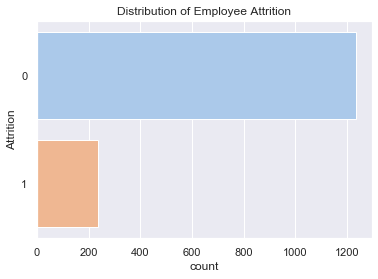

In [9]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Employee Attrition')
sns.countplot(y='Attrition', palette='pastel', data=df)

Around 1200 employees stayed at IBM.

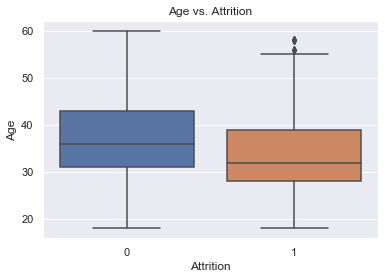

In [10]:
fig, ax = plt.subplots()
ax.set_title('Age vs. Attrition')
sns.boxplot(x='Attrition', y='Age', data=df)

These boxplots show the age distribution of employees that stayed at IBM versus the employees that left. The distribution of employees that left IBM has a mean at approximately  32 years old while the mean of employees that stay is around 36 years old. This shows that younger people are more likely to leave IBM. 

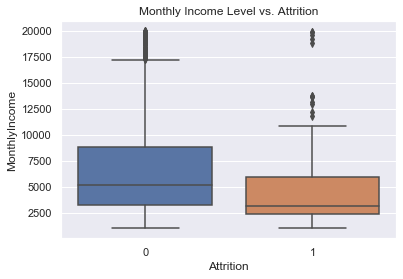

In [11]:
fig, ax = plt.subplots()
ax.set_title('Monthly Income Level vs. Attrition')
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)

These boxplots show the age distribution of employees that stayed at IBM versus the employees that left. The distribution of employees that left IBM has a mean at approximately  32 years old while the mean of employees that stay is around 36 years old. This shows that younger people are more likely to leave IBM. 

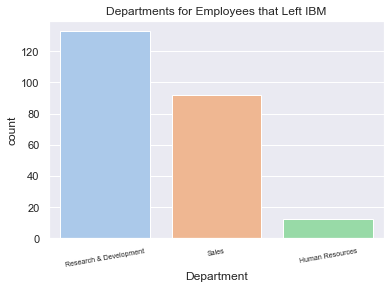

In [12]:
fig, ax = plt.subplots()
  
ax.set_title('Departments for Employees that Left IBM')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7, rotation=10)

sns.countplot(x='Department', palette='pastel', order=attrition_df.Department.value_counts().index, data=attrition_df)

Most of the people who left IBM were in Research and Development at around 140 people, with 90 people in sales and 15 people in Human Resources.

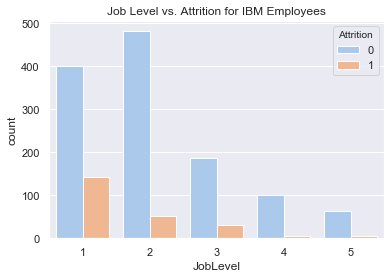

In [13]:
fig, ax = plt.subplots()
ax.set_title('Job Level vs. Attrition for IBM Employees') 
sns.countplot(x='JobLevel', hue='Attrition', palette='pastel', data=df)

This graph shows that entry-level employees are more likely to leave the company than employees at a more senior level. 

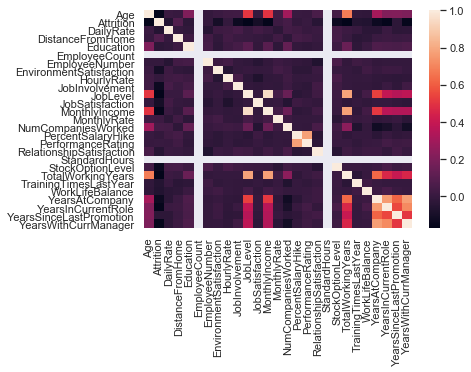

In [14]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Feature Encoding, Scaling, and Final Data Preparations

In [15]:
def far_distance(df):
  """ Create a variable for employees with a long distance from the place of work. """
  if df['DistanceFromHome'] > 10:
    return  1
  else:
    return 0 

df['far_distance'] = df.apply(lambda df:far_distance(df), axis=1)

def young_no_love(df):
  """ Create a variable for employees that are young and have no relationship obligations :( """
  
  if df['Age'] < 27 and df['MaritalStatus'] == 'Single':
    return 1
  else:
    return 0 
  
df['young_no_love'] = df.apply(lambda df:young_no_love(df), axis=1)

def migrating_worker(df):
  """Create a variable for employees that move around companies often. """
  
  if df['NumCompaniesWorked'] > 3:
    return 1 
  else:
    return 0 

df['migrating_worker'] = df.apply(lambda df:migrating_worker(df), axis=1)

# Compare the adjusted hourly wage with the monthly wage to determine how well compensated an employee is based on time spent in office
df['comp_adjusted'] = df['HourlyRate'] / df['MonthlyRate']

# Create a variable that is a ratio of total monthly income to distance from the work location 
df['distance_comp'] = df['MonthlyIncome'] / df['DistanceFromHome']

In [16]:
def prepare_data(employee_df):
#Make the final preparations to feed our data into our machine learning models. 
# Employee ID Column
    id_employee = ['EmployeeNumber']
# Define our target column, this is our predictor 
    target_column = ['Attrition']
# Handle our categorical variables 
    cols_categorical = employee_df.nunique()[employee_df.nunique() < 15].keys().tolist()
    cols_categorical = [col for col in cols_categorical if col not in target_column]
# Hanlde our numerical columns 
    cols_numerical = [col for col in employee_df.columns if col not in cols_categorical + target_column + id_employee]
# Handle our binary columns 
    cols_binary = employee_df.nunique()[employee_df.nunique() == 2].keys().tolist()
# Handle columns with numerouus values 
    cols_numerous = [col for col in cols_categorical if col not in cols_binary]
# Encode our Binary Columns 
    le = LabelEncoder()
    for col in cols_binary:
        employee_df[col] = le.fit_transform(employee_df[col])
# One-Hot Encoding for Categorical Columns 
    employee_df = pd.get_dummies(data = employee_df, columns = cols_numerous)
    return employee_df 

In [17]:
employee_df = prepare_data(df)

# Define X & Y so we can plug into machine learning models

y = np.array(employee_df.Attrition.tolist())

employee_df.drop(['Attrition'], axis=1, inplace=True)
X = np.array(employee_df.values)

# Feauture Elimation for Features with Low Variance (i.e. if a feature has 0 variance, it's unlikely that there are interesting patterns in the data)
select_crit = VarianceThreshold(threshold=(0.8 * (1-0.8)))
select_crit.fit_transform(X)

# Get the Train / Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)

### Logistic Regression Implementation 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of Classifier is 0.832579185520362
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       185
           1       0.00      0.00      0.00        36

    accuracy                           0.83       221
   macro avg       0.42      0.50      0.45       221
weighted avg       0.70      0.83      0.76       221



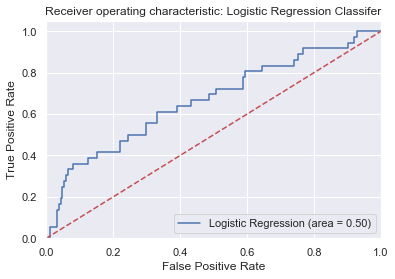

None

In [18]:
def build_logistic_regression():
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
  
    # Make Predictions & Compute Results
    y_pred = logreg.predict(X_test)
    print('Accuracy of Classifier is {}'.format(logreg.score(X_test, y_test)))
    print(classification_report(y_test, y_pred))
  
    # Plot ROC Curve 
    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Logistic Regression Classifer')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    display(plt.show())
    
build_logistic_regression()

### Random Forest Implementation

Accuracy is: 0.8597285067873304


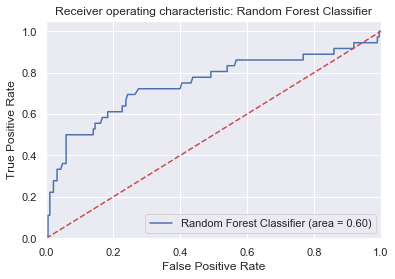

None

In [19]:
def build_random_forest():
    rf = RandomForestClassifier(n_estimators=1000, random_state=12)
    rf.fit(X_train, y_train)
  # Make Predictions and Print Results
    print('Accuracy is: {}'.format(rf.score(X_test, y_test)))  
  
  # Plot ROC Curve 
    rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Random Forest Classifier')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    display(plt.show())

build_random_forest()